In [1]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import kagglehub



c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing Dataset

In [2]:
path = kagglehub.dataset_download("phileinsophos/predict-loan-amount-data")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\phileinsophos\predict-loan-amount-data\versions\1


In [3]:
train = pd.read_csv(f"{path}/train.csv")
test = pd.read_csv(f"{path}/test.csv")

In [4]:
train.shape, test.shape

((30000, 24), (20000, 23))

In [5]:
train.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [6]:
test.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')

So Loan Sanction Amount is the target variable

## Preprocessing

In [7]:
train.drop(columns=['Customer ID','Name','Property ID'], inplace=True)

### Handling missing values

In [8]:
train.isnull().sum()

Gender                           53
Age                               0
Income (USD)                   4576
Income Stability               1683
Profession                        0
Type of Employment             7270
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     172
Expense Type 1                    0
Expense Type 2                    0
Dependents                     2493
Credit Score                   1703
No. of Defaults                   0
Has Active Credit Card         1566
Property Age                   4850
Property Type                     0
Property Location               356
Co-Applicant                      0
Property Price                    0
Loan Sanction Amount (USD)      340
dtype: int64

Gender

Since Gender is a categorical variable mode is used to fill the missing values

In [9]:
train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])

Income

Median is choosen coz using median keeps the overall scale and spread closer to the original distribution.

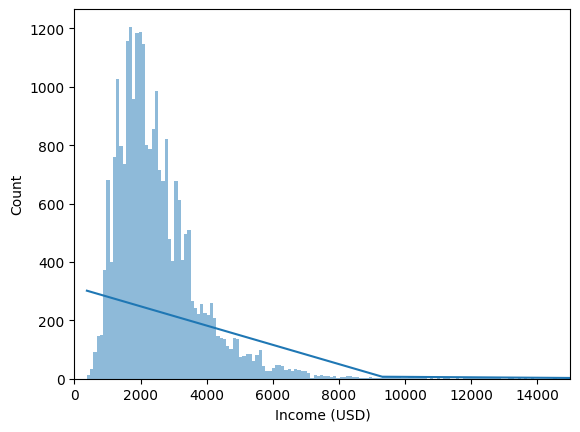

In [10]:
sns.histplot(train['Income (USD)'], kde=True)
plt.xlim(0, 15000)
plt.show()

In skewed distributions, the median is more representative of what most users are like.

In [11]:
train['Income (USD)']=train['Income (USD)'].fillna(train['Income (USD)'].median())


Income Stability

Since Income Stability is a categorical variable mode is used to fill the missing values

In [12]:
train['Income Stability']=train['Income Stability'].fillna(train['Income Stability'].mode()[0])

Type of Employment

Due to high missing value(7270) this column is dropped

In [13]:
train.drop(columns=['Type of Employment'], inplace=True)

Current Loan Expenses (USD)

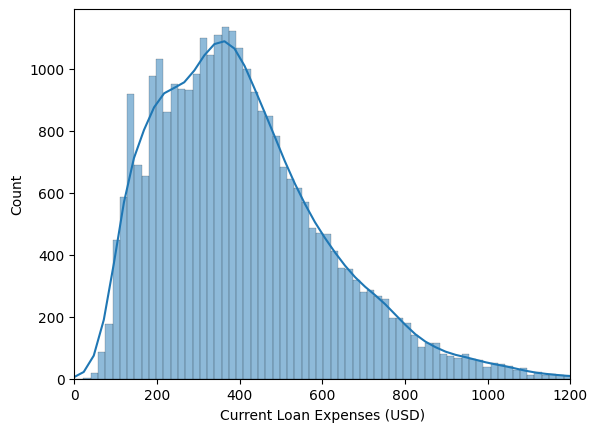

In [14]:
sns.histplot(train['Current Loan Expenses (USD)'], kde=True)
plt.xlim(0,1200)
plt.show()

In skewed distributions, the median is more representative of what most users are like.

In [15]:
train['Current Loan Expenses (USD)']=train['Current Loan Expenses (USD)'].fillna(train['Current Loan Expenses (USD)'].median())

Dependents

In [16]:
train['Dependents']=train['Dependents'].fillna(0)

Credit Score

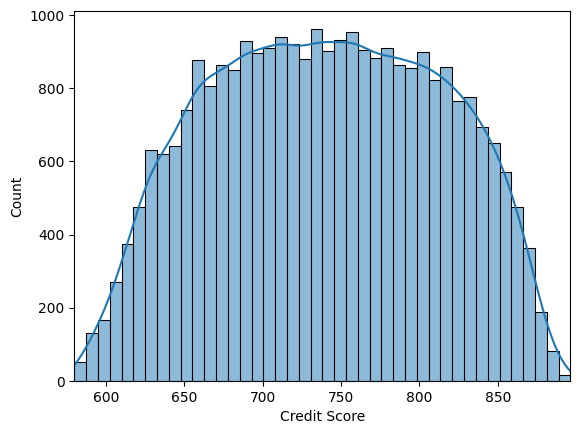

In [17]:
sns.histplot(train['Credit Score'], kde=True)
plt.xlim(train['Credit Score'].min(), train['Credit Score'].max())
plt.show()

Since the credit scores are fairly symmetrical and centered and there aren’t major outliers.Mean can be used

In [18]:
train['Credit Score']=train['Credit Score'].fillna(train['Credit Score'].mean())

Has Active Credit Card

Since it is a categorical feature mode is used.

In [19]:
train['Has Active Credit Card']=train['Has Active Credit Card'].fillna(train['Has Active Credit Card'].mode()[0])

Property Age

In [20]:
train.drop(columns=['Property Age'], inplace=True)

Property Location

Since it is a categorical feature mode is used

In [21]:
train['Property Location']=train['Property Location'].fillna(train['Property Location'].mode()[0])

Loan Sanction Amount

We need the target feature values to make assumptions.

In [22]:
train.dropna(subset=['Loan Sanction Amount (USD)'], inplace=True)

In [23]:
train.isnull().sum()

Gender                         0
Age                            0
Income (USD)                   0
Income Stability               0
Profession                     0
Location                       0
Loan Amount Request (USD)      0
Current Loan Expenses (USD)    0
Expense Type 1                 0
Expense Type 2                 0
Dependents                     0
Credit Score                   0
No. of Defaults                0
Has Active Credit Card         0
Property Type                  0
Property Location              0
Co-Applicant                   0
Property Price                 0
Loan Sanction Amount (USD)     0
dtype: int64

In [24]:
train.shape

(29660, 19)

### Outlier Treatment

In [25]:
train_before = train.copy()

In [26]:
def remove_outliers_iqr(df, columns):
    mask = pd.Series([True] * len(df), index=df.index)
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask &= df[col].between(lower_bound, upper_bound)
    return df[mask]


In [27]:
num_cols_to_check = [
    'Income (USD)',
    'Current Loan Expenses (USD)',
    'Credit Score',
    'Dependents',
    'Loan Amount Request (USD)',
    'Property Price',
    'Loan Sanction Amount (USD)'
]
print("Before:", train.shape)
train = remove_outliers_iqr(train, num_cols_to_check)
print("After:", train.shape)


Before: (29660, 19)
After: (26585, 19)


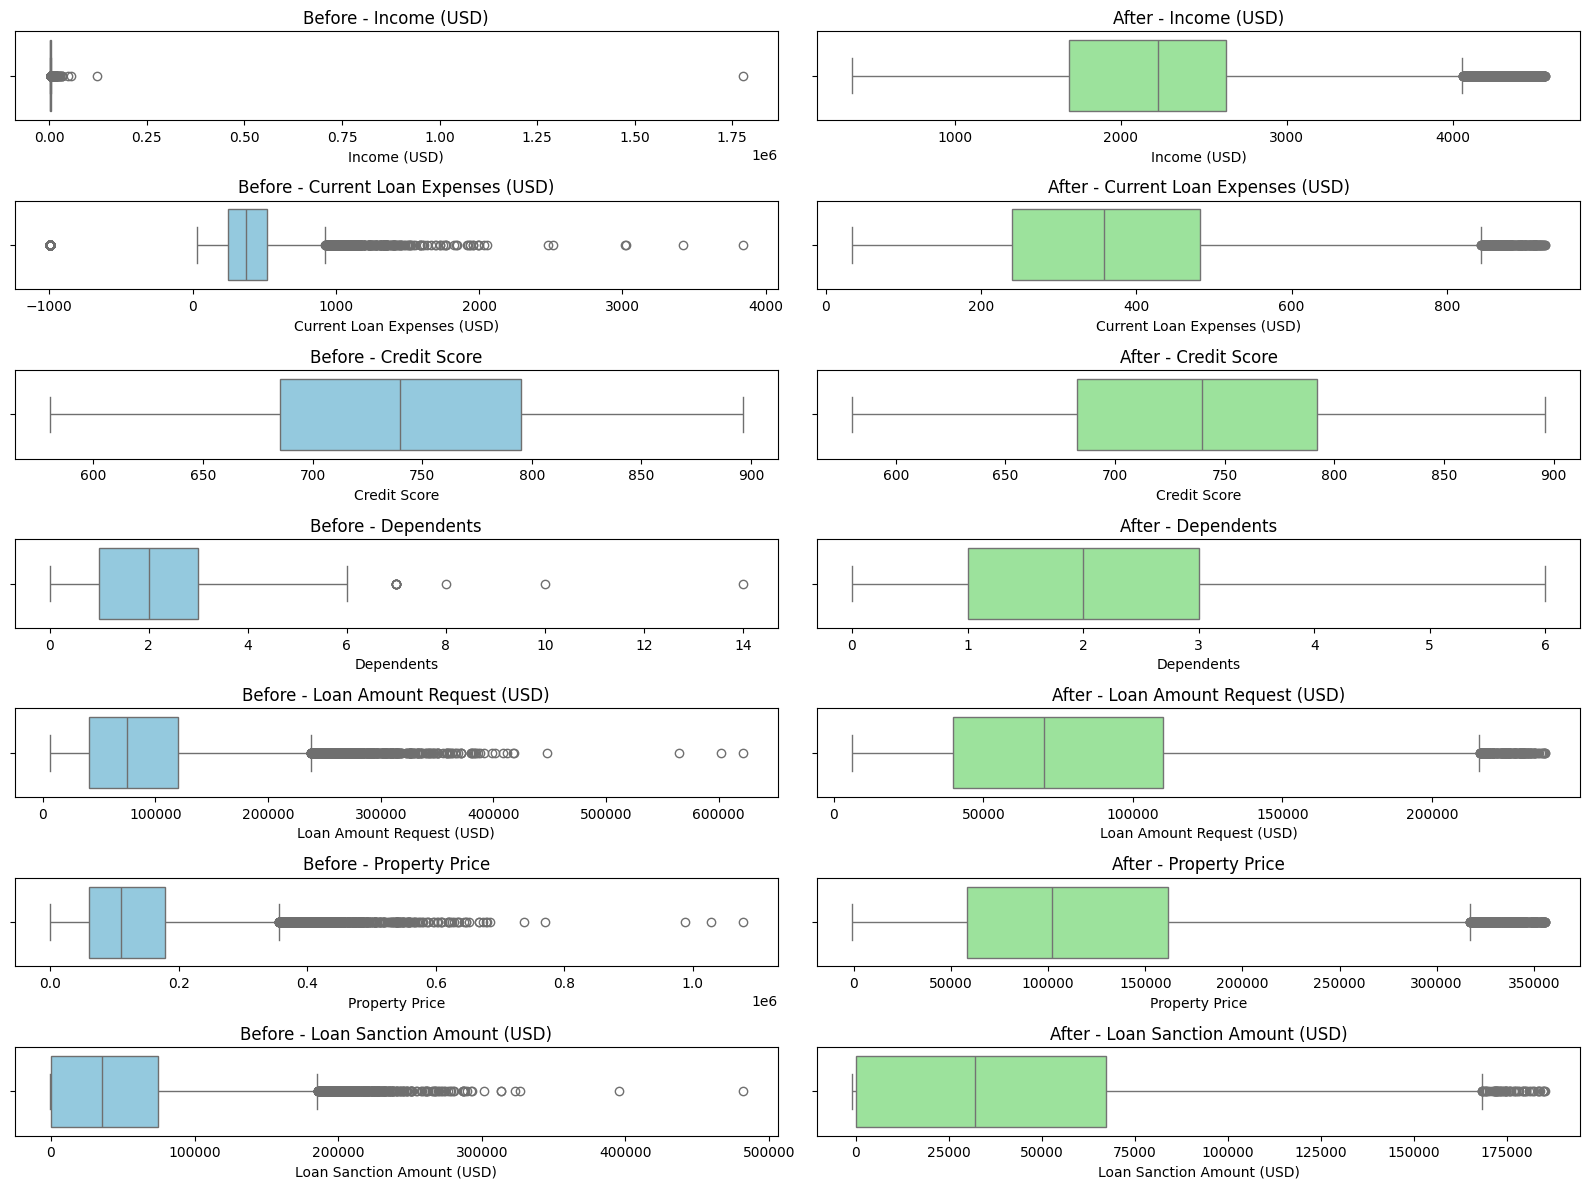

In [28]:
plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(len(num_cols_to_check), 2)

for i, col in enumerate(num_cols_to_check):
    # Before
    ax1 = plt.subplot(gs[i, 0])
    sns.boxplot(x=train_before[col], ax=ax1, color="skyblue")
    ax1.set_title(f"Before - {col}")

    # After
    ax2 = plt.subplot(gs[i, 1])
    sns.boxplot(x=train[col], ax=ax2, color="lightgreen")
    ax2.set_title(f"After - {col}")

plt.tight_layout()
plt.show()

## Exploratory Data Analysis

### Categorical Analysis

#### univariate Analysis

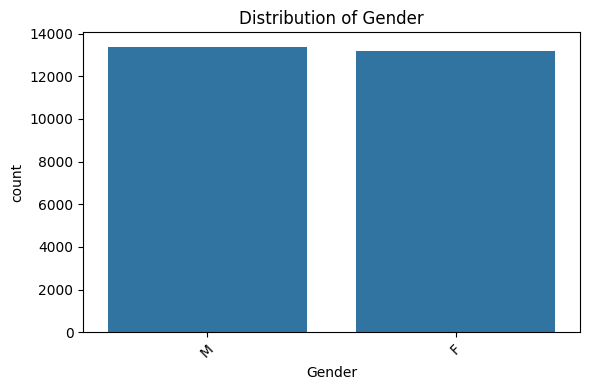

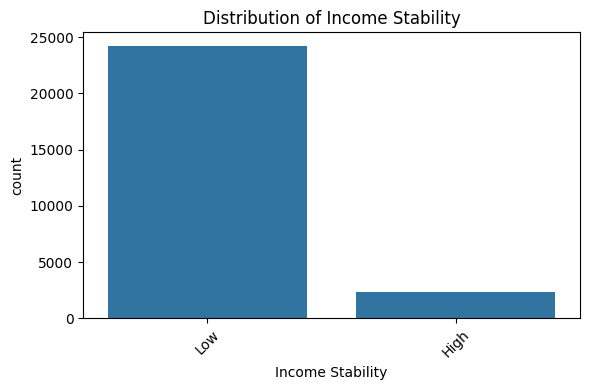

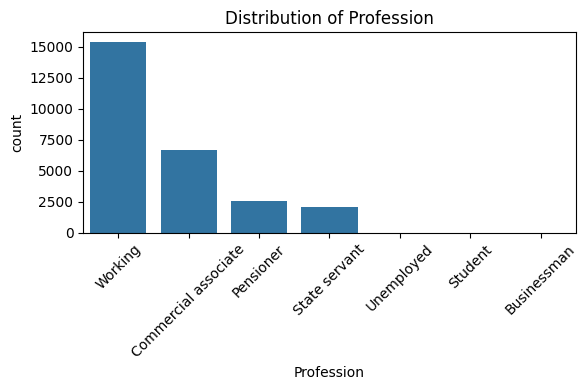

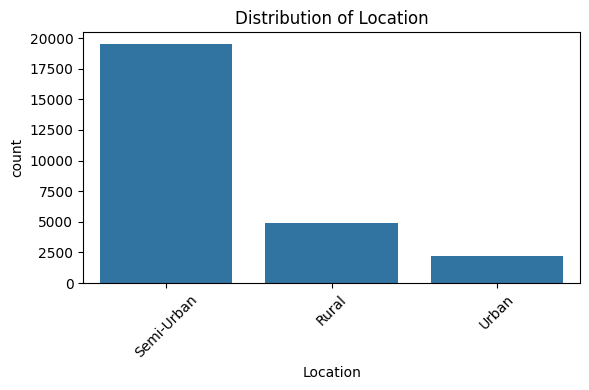

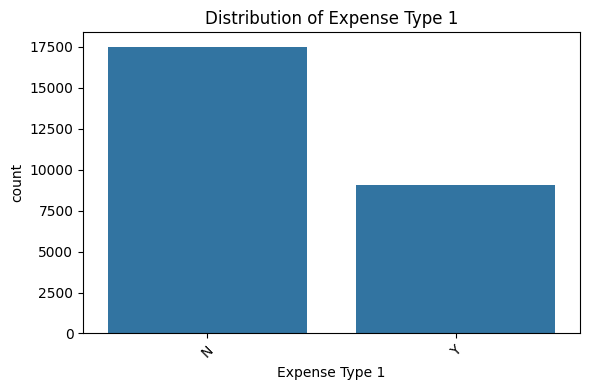

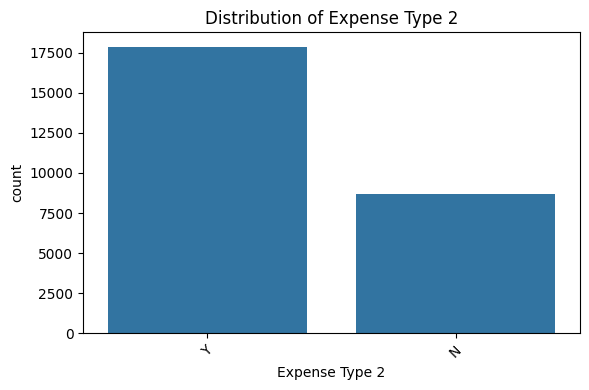

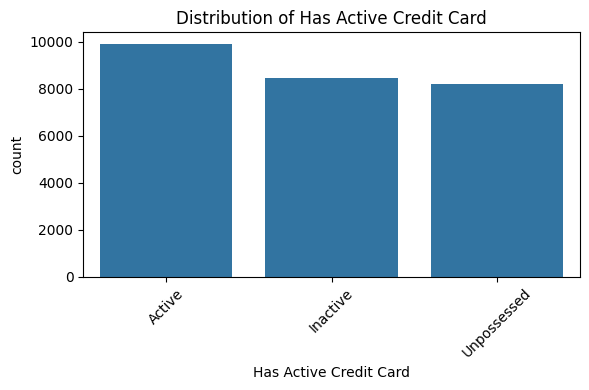

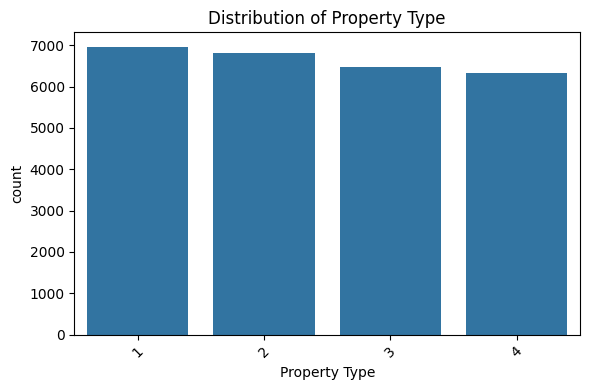

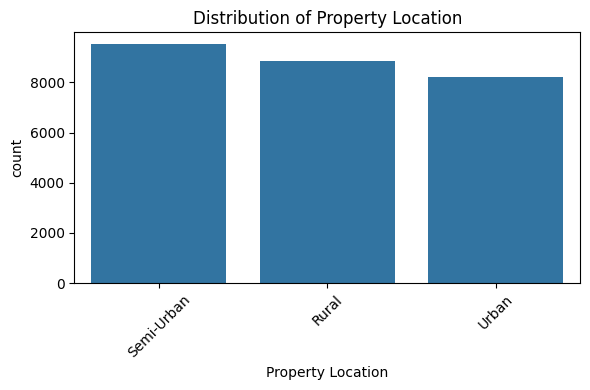

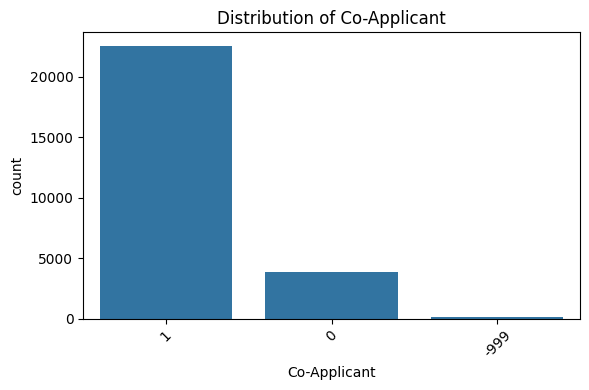

In [29]:
categorical_cols = [
    'Gender',
    'Income Stability',
    'Profession',
    'Location',
    'Expense Type 1',
    'Expense Type 2',
    'Has Active Credit Card',
    'Property Type',
    'Property Location',
    'Co-Applicant'
]
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=train, order=train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Bivariate Analysis

In [30]:
anova_results = []
from scipy.stats import f_oneway
for col in categorical_cols:
    # Perform ANOVA to test if means differ significantly
    groups = [train['Loan Sanction Amount (USD)'][train[col] == level] for level in train[col].dropna().unique()]
    if len(groups) > 1:
        f_stat, p_val = f_oneway(*groups)
        anova_results.append((col, p_val))
anova_df = pd.DataFrame(anova_results, columns=['Categorical Feature', 'p-value'])
anova_df['Significant (p < 0.05)'] = anova_df['p-value'] < 0.05
print("\nANOVA Results:")
print(anova_df.sort_values(by='p-value'))


ANOVA Results:
      Categorical Feature       p-value  Significant (p < 0.05)
9            Co-Applicant  0.000000e+00                    True
2              Profession  2.255225e-47                    True
3                Location  7.629250e-32                    True
1        Income Stability  5.085348e-20                    True
4          Expense Type 1  8.267140e-05                    True
5          Expense Type 2  7.128996e-02                   False
6  Has Active Credit Card  8.565205e-02                   False
8       Property Location  1.600163e-01                   False
0                  Gender  7.343009e-01                   False
7           Property Type  8.729814e-01                   False


In [31]:
train.drop(columns=['Expense Type 2','Has Active Credit Card','Property Location','Gender','Property Type'], inplace=True)

### Numerical Analysis

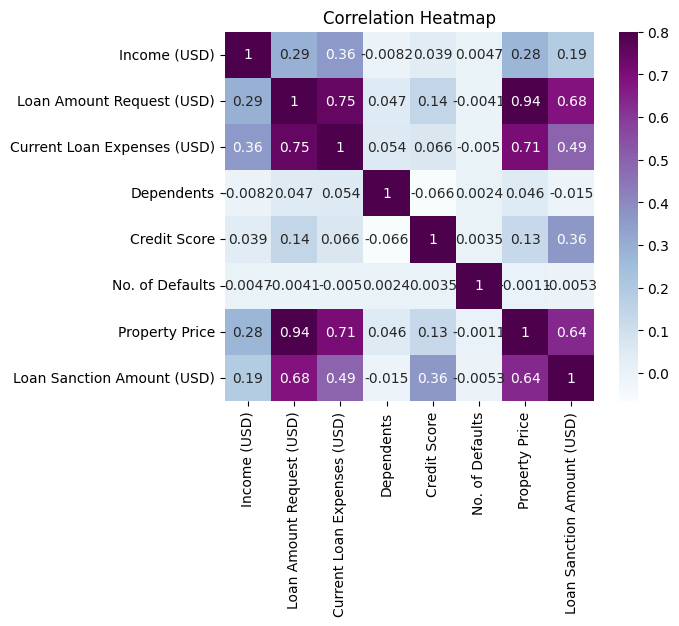

In [32]:
matrix = train[['Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)','Dependents','Credit Score','No. of Defaults','Property Price','Loan Sanction Amount (USD)']].corr()
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu",annot=True)
plt.title('Correlation Heatmap')
plt.show()


Dropping Dependents and No. of Defaults due to weak correlation

In [33]:
train.drop(columns=['Dependents','No. of Defaults'], inplace=True)

### Encoding Categorical Columns

In [34]:
categorical_cols = [
    'Income Stability',
    'Profession',
    'Location',
    'Expense Type 1',
    'Co-Applicant'
]
train[categorical_cols].nunique()


Income Stability    2
Profession          7
Location            3
Expense Type 1      2
Co-Applicant        3
dtype: int64

In [35]:
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)


In [36]:
train_encoded.columns

Index(['Age', 'Income (USD)', 'Loan Amount Request (USD)',
       'Current Loan Expenses (USD)', 'Credit Score', 'Property Price',
       'Loan Sanction Amount (USD)', 'Income Stability_Low',
       'Profession_Commercial associate', 'Profession_Pensioner',
       'Profession_State servant', 'Profession_Student',
       'Profession_Unemployed', 'Profession_Working', 'Location_Semi-Urban',
       'Location_Urban', 'Expense Type 1_Y', 'Co-Applicant_0',
       'Co-Applicant_1'],
      dtype='object')

### Standardize

In [37]:
from sklearn.preprocessing import StandardScaler
target = 'Loan Sanction Amount (USD)'
numerical_features = ['Age', 'Income (USD)', 'Loan Amount Request (USD)',
                      'Current Loan Expenses (USD)', 'Credit Score', 'Property Price']

# Standardize numeric features
scaler = StandardScaler()
train_encoded[numerical_features] = scaler.fit_transform(train_encoded[numerical_features])

## Modeling

In [41]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

K-FOLD CROSS VALIDATION

In [42]:
X = train_encoded.drop(columns=["Loan Sanction Amount (USD)"])
y = train_encoded["Loan Sanction Amount (USD)"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print("Performing 5-Fold CV on Training Set")
lr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
mae_scores = []
r2_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lr.fit(X_t, y_t)
    preds = lr.predict(X_v)

    mse = mean_squared_error(y_v, preds)
    mae = mean_absolute_error(y_v, preds)
    r2 = r2_score(y_v, preds)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold} — MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

print("\n Average CV Performance:")
print(f"Avg MSE: {np.mean(mse_scores):.2f}")
print(f"Avg MAE: {np.mean(mae_scores):.2f}")
print(f"Avg R²: {np.mean(r2_scores):.2f}")


Performing 5-Fold CV on Training Set
Fold 1 — MSE: 617243258.78, MAE: 17414.54, R²: 0.61
Fold 2 — MSE: 637814227.93, MAE: 17826.16, R²: 0.61
Fold 3 — MSE: 618047080.23, MAE: 17646.17, R²: 0.62
Fold 4 — MSE: 658150344.53, MAE: 17989.57, R²: 0.60
Fold 5 — MSE: 650893584.19, MAE: 18052.41, R²: 0.61

 Average CV Performance:
Avg MSE: 636429699.13
Avg MAE: 17785.77
Avg R²: 0.61


FINAL TRAINING ON FULL TRAIN SET

In [43]:
print("\n Training Final Model on Full Training Data")
lr.fit(X_train, y_train)


 Training Final Model on Full Training Data


LinearRegression()

VALIDATION SET EVALUATION

In [44]:
val_preds = lr.predict(X_val)
print("\nValidation Set Evaluation:")
print(f"Validation MSE: {mean_squared_error(y_val, val_preds):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_val, val_preds):.2f}")
print(f"Validation R²: {r2_score(y_val, val_preds):.2f}")


Validation Set Evaluation:
Validation MSE: 629700625.85
Validation MAE: 17624.04
Validation R²: 0.61


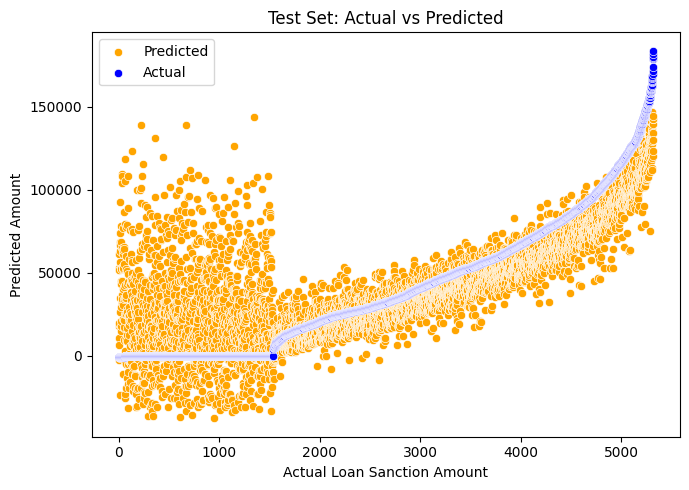

In [45]:
plt.figure(figsize=(7,5))
sorted_idx = y_val.sort_values().index
y_val_sorted = y_val.loc[sorted_idx].reset_index(drop=True)
val_preds_sorted = pd.Series(val_preds, index=y_val.index).loc[sorted_idx].reset_index(drop=True)

plt.xlabel("Actual Loan Sanction Amount")
plt.ylabel("Predicted Amount")
plt.title("Test Set: Actual vs Predicted")
sns.scatterplot(x=range(len(val_preds_sorted)), y=val_preds_sorted, label="Predicted", color="orange")
sns.scatterplot(x=range(len(y_val_sorted)), y=y_val_sorted, label="Actual", color="blue")
plt.tight_layout()
plt.show()

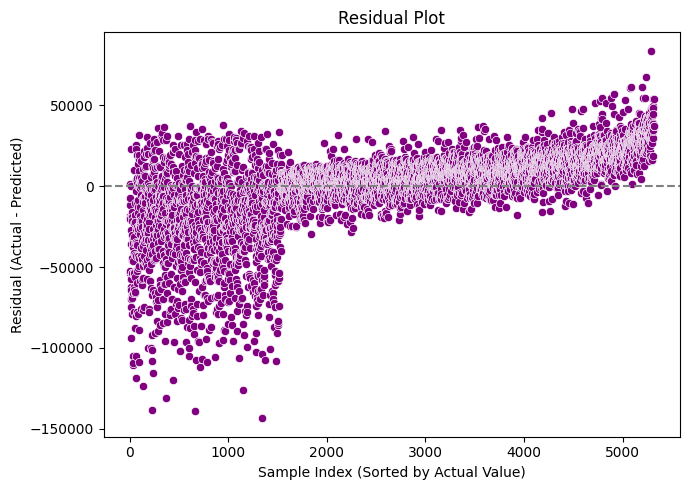

In [46]:
# Residual Plot
plt.figure(figsize=(7, 5))
residuals = y_val_sorted - val_preds_sorted

plt.axhline(0, color='gray', linestyle='--')
sns.scatterplot(x=range(len(residuals)), y=residuals, color='purple')
plt.xlabel("Sample Index (Sorted by Actual Value)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_2064\1976656691.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.values, y=coef_df.index, palette="coolwarm")


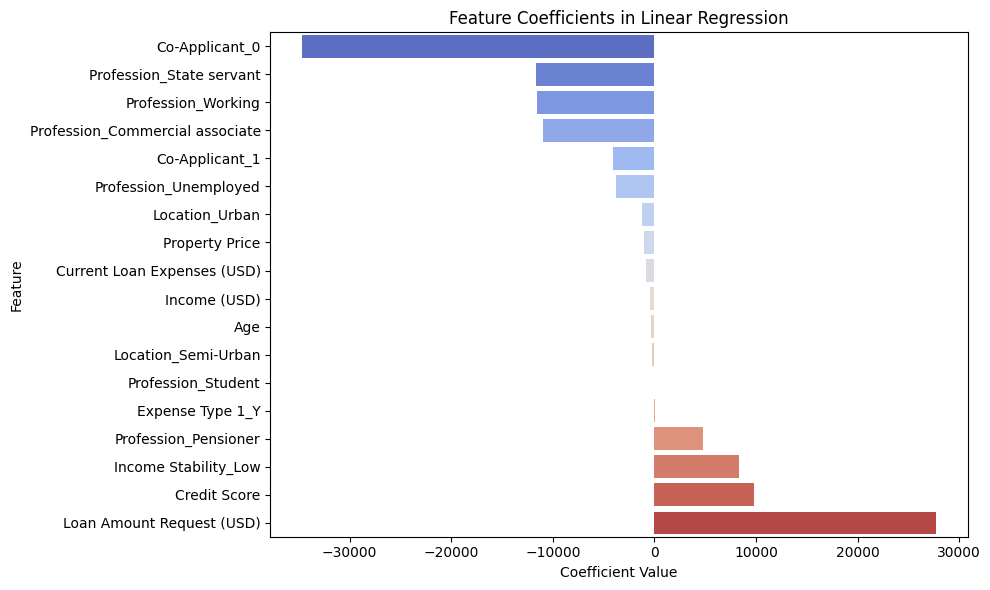

In [48]:
# Bar Plot of Feature Coefficients
plt.figure(figsize=(10, 6))
coefficients = lr.coef_
feature_names = X_train.columns  # replace with actual feature list if needed

coef_df = pd.Series(coefficients, index=feature_names).sort_values()

sns.barplot(x=coef_df.values, y=coef_df.index, palette="coolwarm")
plt.title("Feature Coefficients in Linear Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
